<a href="https://colab.research.google.com/github/Raoufmamedov/various_studies/blob/main/Churn%20study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Изучение оттока клиентов банка

## Введение

### Постановка задачи

В нашем распоряжении имеются данные об оттоке клиентов международного банка. Задачей банка является разработка компании лояльности для удержания клиентов, и для этого ему необходимо выявить факторы связанные с оттком клиентов. Сделать это проще всего сравнив профили клиентов покинувших банк с профилями клиентов сохранивших свою лояльность, а также выявить взаимосвязь признаков определяющих поведение клиентов. После проведения разведовательного внализа, банк сможет отобрать признаки которые статистически значимо влияют на решение клиента, и построить на их осннове модель машинного обучения, способную прогнозировать уход клиента.

### Подготовительные действия

В работе мы будем использовать библиотеки Pandas, Marplotlib, Seaborn Plotly. Загружаем библиотеки

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as ex
import warnings
warnings.simplefilter("ignore")

In [69]:
from google.colab import drive

In [70]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Знакомство с датасетом

Загружаем файл данных и смотрим какие признаки он содержит.

In [71]:
import pandas as pd
churn_df=pd.read_csv('/content/drive/MyDrive/churn.csv')
churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [72]:
churn_df.shape

(10000, 14)

Итак, у нас имеются записи по 10000 клиентам и следующие 14 признаков (целевой признак Exited и 13 предикторов):

    * RowNumber — номер строки таблицы (это лишняя информация, поэтому можете сразу от неё избавиться)
    * CustomerId — идентификатор клиента
    * Surname — фамилия клиента
    * CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их)
    * Geography — страна клиента (банк международный)
    * Gender — пол клиента
    * Age — возраст клиента
    * Tenure — сколько лет клиент пользуется услугами банка
    * Balance — баланс на счетах клиента в банке
    * NumOfProducts — количество услуг банка, которые приобрёл клиент
    * HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет)
    * IsActiveMember — есть ли у клиента статус активного клиента банка (1 — да, 0 — нет)
    * EstimatedSalary — предполагаемая заработная плата клиента
    * Exited — статус лояльности (1 — ушедший клиент, 0 — лояльный клиент)

Как мы видим,некоторые из признаков не имеют для нас никакой ценности, поэтому мы удаляем их. Посмотрим, имеются ли пропуски в данных

In [73]:
churn_df=churn_df[['CustomerId', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']]

In [74]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   CreditScore      10000 non-null  int64  
 2   Geography        10000 non-null  object 
 3   Gender           10000 non-null  object 
 4   Age              10000 non-null  int64  
 5   Tenure           10000 non-null  int64  
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasCrCard        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


Пропуски в данных отсутствуют. Проанализируем какое количество значений принимают переменные

In [75]:
churn_df.nunique()

,0
CustomerId,10000
CreditScore,460
Geography,3
Gender,2
Age,70
Tenure,11
Balance,6382
NumOfProducts,4
HasCrCard,2
IsActiveMember,2


Итак, наряду с бинарным целевым признаком, у нас имеются бинарные признаки пола,
наличия кредитной карты, наличие статуса активного клиента. Также у нас имеются категориальная переменная страны проживания
и порядковая переменная количества продуктов. Остальные переменные являются количественными переменными.

## План действий

При анализе данных, мы будем руководствоваться следующим плавном действий

1. Определим соотношение ушедших и лояльных клиентов.

2. Оценим распределение баланса счетов у пользователей. Мы будем рассматривать данные по балансу пользователей, у которых на счету больше 2 500 долларов.

3. Посмотрим на распределение баланса клиента в разрезе признака оттока.

4. Выясним влияет ли возраст на лояльность и определим возрастную категорию клиентов на которую банку необходимо обратить внимание

5. Изучим зависимость взаимосвязь кредитного рейтинга клиента и его предполагаемой зарплаты.

6. Посмотрим, есть ли какие-то различия в лояльности мужчин и женщин.

7. Оценим зависимость оттока от количества услуг оказываемых банком.

8. Выясним, влияет ли наличие статуса активного клиента на отток клиентов.

9. Определим страну в которой выше доля ушедших клиентов.

10. Оценим взаимосвязь кредитного рейтинга и клиентского стажа. Выявим клиентов склонных к уходу из банку.

### 1. Количественное соотношение клиентов

Наш анализ признаков мы начнём с оценки оттока клиентов из банка

In [76]:
churn=churn_df['Exited'].value_counts(normalize=True)*100


Text(0.5, 1.0, 'Круговая диаграмма оттока клиентов')

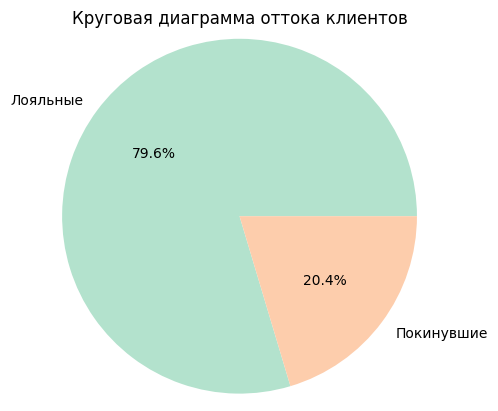

In [77]:
plt.pie(churn, labels=['Лояльные', 'Покинувшие'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        radius=1.2)
plt.title("Круговая диаграмма оттока клиентов")

Итак, банк покинул каждый пятый клиент. Оценим распределения суммарного объём средств на счетах.

Text(0.5, 1.0, 'Круговая диаграмма суммарного баланса счетов')

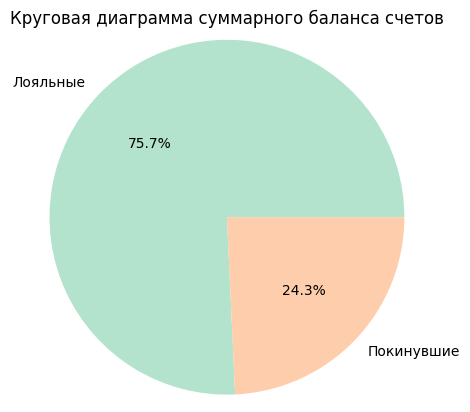

In [78]:
churnbal=churn_df.groupby('Exited').Balance.sum()
plt.pie(churnbal, labels=['Лояльные', 'Покинувшие'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        radius=1.2)
plt.title("Круговая диаграмма суммарного баланса счетов")

На покинувших банк клиентов приходится каждое четвёртое евро на счетах. Мы будем использовать это значение в качестве базовой линии при оценке оттока отмечаемого для определённых значениях баланса. Далее мы рассмотрим признаки которые оказывают влияние на отток клиентов и изучим их взаимосвязь.

### 6. Половой состав клиентов банка

Выясним сколько среди клиентов банка мужчин и сколько женщин

,count
Gender,
Male,5457
Female,4543


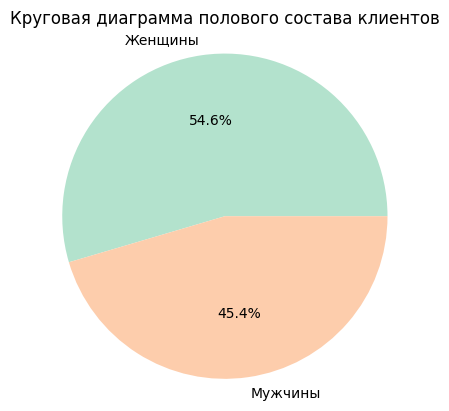

In [79]:
gender=churn_df.Gender.value_counts()
plt.pie(gender, labels=['Женщины', 'Мужчины'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        radius=1.1)
plt.title("Круговая диаграмма полового состава клиентов")
gender

А теперь посмотрим, изменяется ли соотношение клиентов мужского и женского пола среди нелояльных клиентов?

,count
Gender,
Female,1139
Male,898


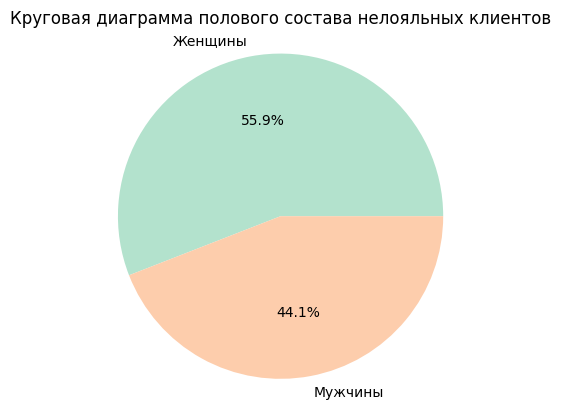

In [80]:
churngender=churn_df[churn_df.Exited==1].Gender.value_counts()
plt.pie(churngender, labels=['Женщины', 'Мужчины'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        radius=1.1)
plt.title("Круговая диаграмма полового состава нелояльных клиентов")
churngender

Цифры практически идентичны и пол не является признаком позволяющим дифференцировать потенциально нелояльных клиентов.

### 2. График распределения баланса пользователей в разрезе лояльности

Для определения характера распределения сумм на счетах клиентов, построим гистограмму в разрезе решений клиента
по сотрудничеству с банком.

Text(0.5, 1.0, 'Распределение баланса')

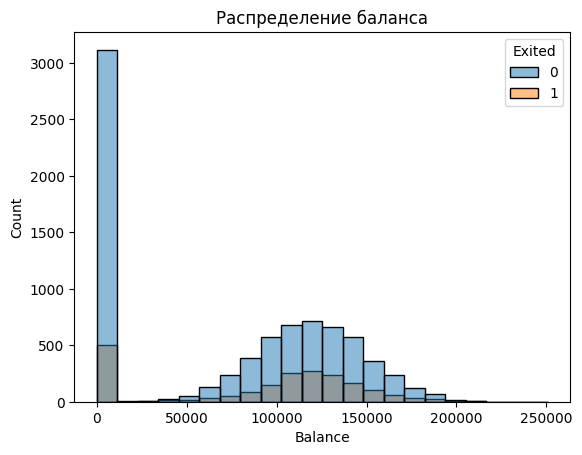

In [81]:
sns.histplot(x=churn_df['Balance'],
             hue=churn_df['Exited'])
plt.title("Распределение баланса")


Судя по гистограмме, у нас имеются нулевые значения баланса. Определим их количество

In [82]:
churn_df[churn_df['Balance']==0].CustomerId.count()

np.int64(3617)

На гистограмме отчётливо видно что для более 3617 клиентских счетов мы имеем нулевой баланс, что составляет 36% счетов банка.

**<span style="color:crimson;"> ВАЖНО!: </span>**
    
<span style="color:crimson;">Поскольку по счетам с нулевым балансому нас отсутствует информация, позволяющая понять причину по которой на этих счетах нет денежных средств (счёт обнулён и неиспользуется ; средства выведены на другой счёт этого клиента в банке ; клиент получает зарплату и сразу же снимает все деньги; клиент открыл счёт но ещё не внёс на него денежные средства, прочие возможные причины). Поэтому формально мы не имеем права исключать эти позиции из рассмотрения как неинформативные (возможно клиент открыл счёт и ждёт многомилионное наследство :) ), однако при рассчёте средних значений мы в дальнейшем будем учитывать только ненулевые балансы.  </span>

Посмотрим, сколько среди клиентов с нулевым счётом покинувших банк.

Text(0.5, 1.0, 'Круговая диаграмма оттока клиентов с нулевым балансом')

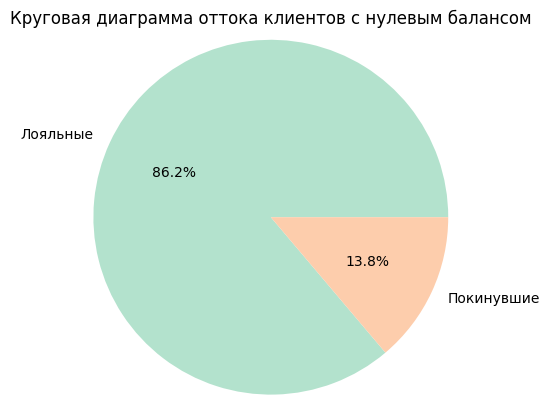

In [83]:
zchurn_bal=churn_df[churn_df.Balance==0]['Exited'].value_counts(normalize=True)*100
plt.pie(zchurn_bal,
        labels=['Лояльные', 'Покинувшие'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        radius=1.2)
plt.title("Круговая диаграмма оттока клиентов с нулевым балансом")

Таким образом, среди владельцев счетов с нулевым балансом, доля покинувших банк меньше чем в целом по счетам. Возможно мы имеем молчаливый отток клиентов либо лояльные клиенты с нулевым балансом по каким-то причинам держатся за этот банк.  Соответственно для ненулевых счетов у нас получается следующая картина:

Text(0.5, 1.0, 'Круговая диаграмма оттока клиентов с ненулевым балансом')

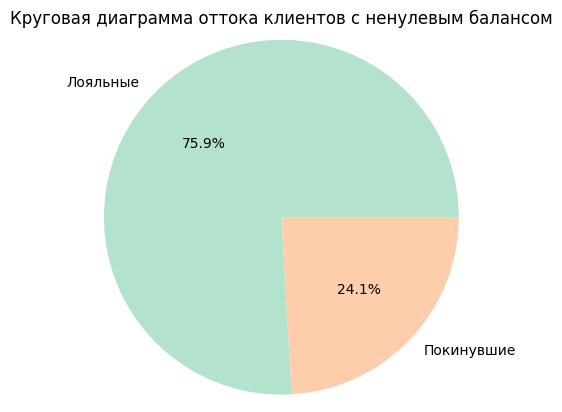

In [84]:
nzchurn_bal=churn_df[churn_df.Balance>0]['Exited'].value_counts(normalize=True)*100
plt.pie(nzchurn_bal,
        labels=['Лояльные', 'Покинувшие'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        radius=1.2)
plt.title("Круговая диаграмма оттока клиентов с ненулевым балансом")

Среди клиентов сненулевыми счетами, количество покинувших возрастает. Теперь это уже почти каждый четвёртый клиент!

Судя по гистограмме, первые ненулевые значения баланса у нас наблюдаются в районе 25000 Евро. Построим гистограмму распределения в диапазоне от 1 до 25000 евро с количеством интервалов=5.

Text(0.5, 1.0, 'Распределение баланса')

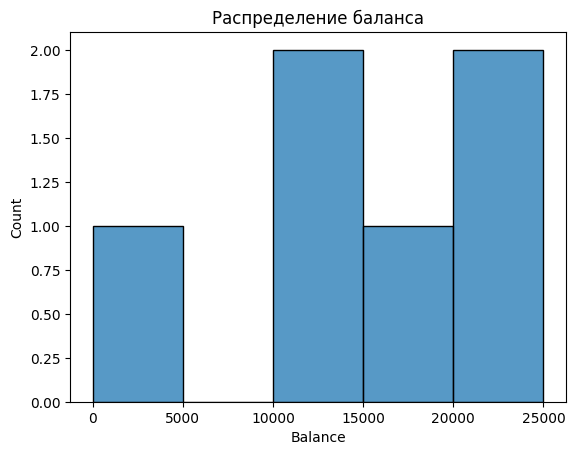

In [85]:
sns.histplot(x=churn_df['Balance'],
             bins=5,
             binrange=(1, 25000))
plt.title("Распределение баланса")

В диапазоне 1-25000 Евро мы дополнительно обнаружили 6 клиентов. Посмотрим каков минимальный размер вклада.

In [86]:
balmin=churn_df[churn_df['Balance']>0]['Balance'].min()


Для удобства построения гистограммы зададимся нижней границей баkанса равной 2500 Евро. Перерисуем основную гистограмму в разрезе лояльности.

Text(0.5, 1.0, 'Распределение баланса в разрезе лояльности')

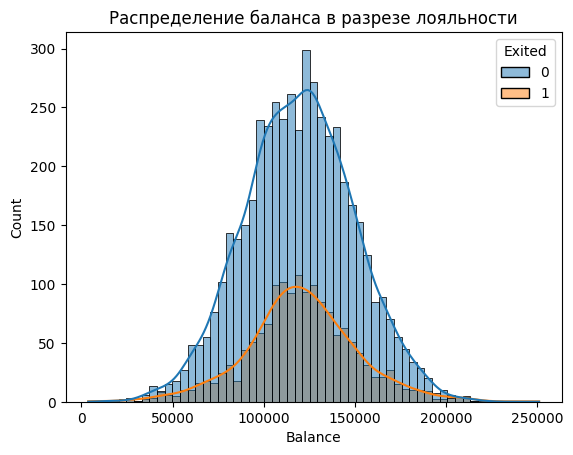

In [87]:
nzchurn=churn_df[churn_df['Balance']>2500]
sns.histplot(x=nzchurn['Balance'],
             hue=churn_df['Exited'], multiple='layer', element='bars',
             kde=True)
plt.title("Распределение баланса в разрезе лояльности")


Мы видим, что оба распределения являются нормальными и имеют очень близкие модальные значения.
Исходя из гистограммы, распределение балансов у покинувших банк и оставшихся в нём клиентов одинаковое, но у распределения нелояльных клиентов более тяжёлый правых хвост. Посмотрим rкакую долю в суммарном распределении балансов составляют распределения лояльных и нелояльных клиентов.

Text(0.5, 1.0, 'Распределение баланса в разрезе лояльности')

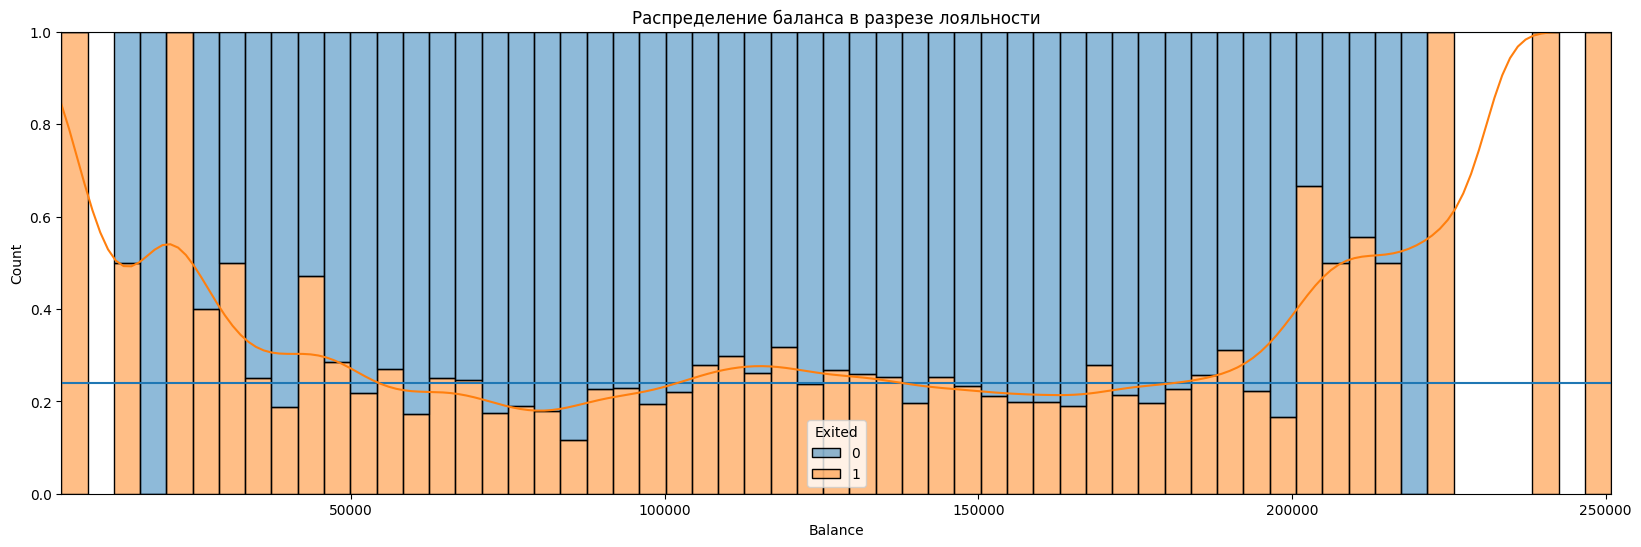

In [88]:
nzchurn=churn_df[churn_df['Balance']>0]
plt.figure(figsize=(20, 6))
plt.axhline(0.24)
sns.histplot(x=nzchurn['Balance'],
             hue=churn_df['Exited'], multiple='fill', element='bars',
             kde=True, )
plt.title("Распределение баланса в разрезе лояльности")

Итак мы видим что в диапазоне до 50 тыс евро и после 200 тыс. евро у нас иммет место повышенный отток клиентов. Посмотрим суммарные балансы этих подгрупп.


In [89]:
below50=churn_df.query('0<Balance<50000')

In [90]:
print("суммарный баланс счетов до 50000 Евро:", round(below50.Balance.sum()), 'Евро')

суммарный баланс счетов до 50000 Евро: 2958565 Евро


In [91]:
above200=churn_df[churn_df['Balance']>200000]

In [92]:
print("суммарный баланс счетов свыше 200000 Евро:", round(above200.Balance.sum()))

суммарный баланс счетов свыше 200000 Евро: 7147131


Оценим оттоки для этих групп

In [93]:
round(below50.Exited.mean(),2)

np.float64(0.35)

In [94]:
round(above200.Exited.mean(), 2)

np.float64(0.56)

Оценим вклад этой группы клиентов в суммарный баланс банка.

In [95]:
(below50.Balance.sum()+above200.Balance.sum())*100/churn_df.Balance.sum()

np.float64(1.3212497683001379)

Итак вклад этой группы клиентов составляет 1,3% от всех средств на счетах клиентов банка.  Если программа повышения лояльности  для этой группы окупится,
то целесообразно в первую очередь обратить внимание на клиентов с балансом счёта 200 000, похоже их что-то не устраивает,
либо банки-конкуренты предлагают условия повыгоднее. Также можно разработать программу лояльности для клиентов с балансами до 50000 Евро.

## 4.  Влияние возраста на отток клиента

Рассмотрим как изменяется возраст клиентов в разрезе их лояльности.

Text(0.5, 1.0, 'Возраст клиентов в разрезе лояльности')

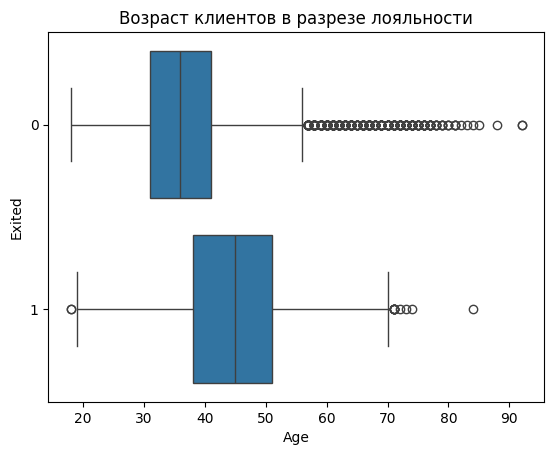

In [96]:
sns.boxplot(x=churn_df['Age'], y=churn_df["Exited"], orient="h") #
plt.title("Возраст клиентов в разрезе лояльности")

Как мы видим:
1) Основное количество наблюдений для лояльных клиентов находится в диапазоне 20-55 лет. Имеется заметное количество выбросов, но соответствующие им наблюдения не следует исключать из рассмотрения. В целом распределение нормальное хотя и  правым тяжёлым хвостом. Меданное значение у лояльных клиентов находится в районе 35 лет.
2) Для нелояльных клиентов диапазон значений шире, он охватывает возраст от 20 до 70 лет. Количество выбросов незначительное. Медианное значение у нелояльных смещено вправо и составляет 45 лет.
3) Таким образом, нелояльный клиент медианно старше лояльного на 10 лет. А клиенты старше 55 лет представляют собой "группу риска". Возможно у нелояльной их части, по мере приближения к пенсионному возрасту обостряется желание выбрать банк получше.

Выясним, каков процент клиентов покинувших банк в возрастной группе 55+

Text(0.5, 1.0, 'Круговая диаграмма оттока клиентов старше 55 лет')

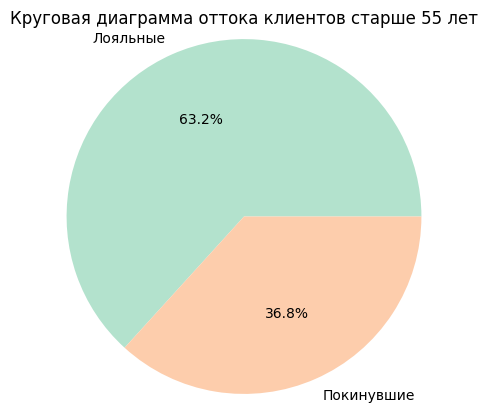

In [97]:
churn_df55=churn_df[churn_df['Age']>55] #Отток клиентов старшее 55 лет
churn55=churn_df55.groupby('Exited').CustomerId.count()
plt.pie(churn55, labels=['Лояльные', 'Покинувшие'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        radius=1.2)
plt.title("Круговая диаграмма оттока клиентов старше 55 лет")

Из этой диаграммы видно, что банк покидает каждый третий клиент в возрасте от 55 лет.
Следовательно необходима разработка мер по повышению лояльности клиентов этой возрастной группы.
Посмотрим, одинаково ли поведение мужчин и женщин этого возраста.


Text(0.5, 1.0, 'Круговая диаграмма оттока женщин старше 55 лет')

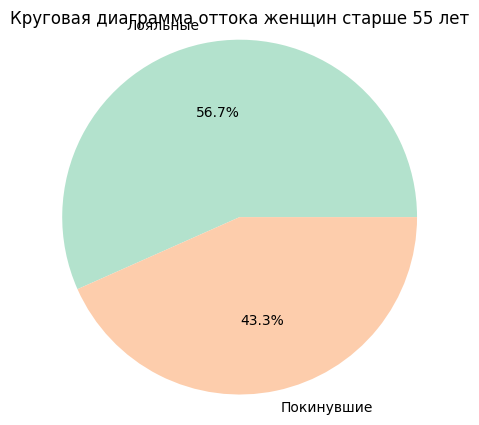

In [98]:
churn_df55f=churn_df[churn_df['Age']>55][churn_df['Gender']=="Female"] # Женщины старше 55
churn55f=churn_df55f.groupby('Exited').CustomerId.count()# Отток женщин старше 55
plt.pie(churn55f, labels=['Лояльные', 'Покинувшие'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        radius=1.2)
plt.title("Круговая диаграмма оттока женщин старше 55 лет")

Text(0.5, 1.0, 'Круговая диаграмма оттока мужчин старше 55 лет')

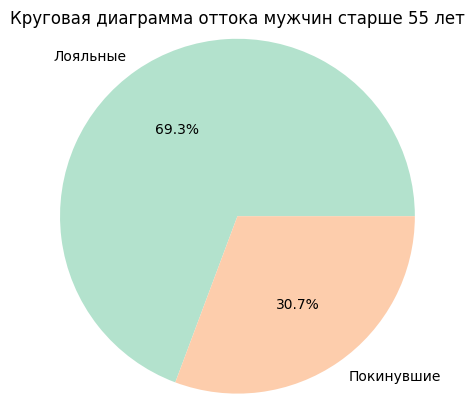

In [99]:
churn_df55m=churn_df[churn_df['Age']>55][churn_df['Gender']=="Male"] # Мужчины старше 55
churn55m=churn_df55m.groupby('Exited').CustomerId.count() # Отток мужчин старше 55
plt.pie(churn55m, labels=['Лояльные', 'Покинувшие'], colors=sns.color_palette('Pastel2'), autopct='%.1f%%', radius=1.2)
plt.title("Круговая диаграмма оттока мужчин старше 55 лет")

Итак, женщины старше 55 лет демонстрируют большую нелояльность банку чем мужчины и требуют особого внимания. Мы можем посмотреть каков суммарный баланс счетов клиентов.

In [100]:
m55bal=churn_df55m.Balance.sum() #Баланс счетов мужчин за 55

In [101]:
f55bal=churn_df55f.Balance.sum() #Баланс счетов женщин за 55


In [102]:
churn_female_balance=churn_df55f.groupby("Exited")['Balance'].sum() #Распределение балансов женщин за 55 по лояльности

In [103]:
churn_male_balance=churn_df55m.groupby("Exited")['Balance'].sum() #Распределение балансов мужчин за 55 по лояльности

Text(0.5, 1.0, 'Круговая диаграмма суммарных балансов счетов женщин старше 55 лет в разрезе лояльности')

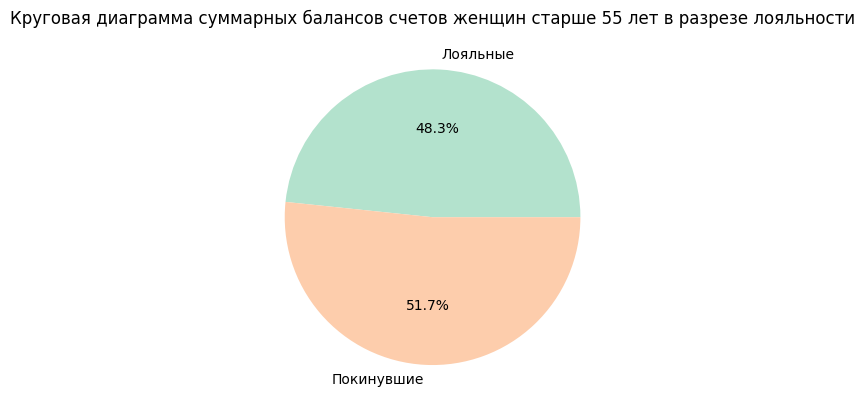

In [104]:
plt.pie(churn_female_balance, labels=['Лояльные', 'Покинувшие'], colors=sns.color_palette('Pastel2'), autopct='%.1f%%', radius=1)
plt.title("Круговая диаграмма суммарных балансов счетов женщин старше 55 лет в разрезе лояльности")

Клиенты-женщины этой возрастной группы на момент ухода из банка, имели на счетах чуть более половины средств находящихся у клиентов в этом половозрастном разрезе. А как обстоит дело в случае мужчин за 55?

Text(0.5, 1.0, 'Круговая диаграмма суммарных балансов счетов женщин старше 55 лет в разрезе лояльности')

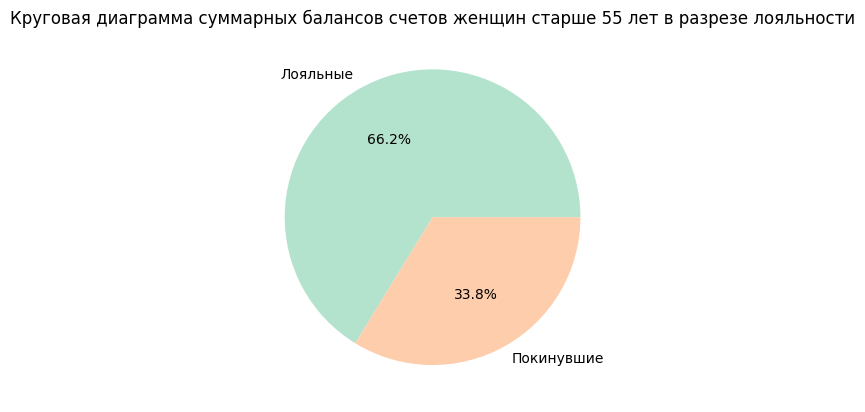

In [105]:
plt.pie(churn_male_balance, labels=['Лояльные', 'Покинувшие'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%', radius=1)
plt.title("Круговая диаграмма суммарных балансов счетов женщин старше 55 лет в разрезе лояльности")

Доля суммы балансов счетов для нелояльных банку мужчин за 55 составляет треть от общего суммарного баланса мужчин этого возраста.
Наконец посмотрим какую долю от суммарного баланса счетов банка составляет суммарный баланс нелояльных клиентов старше 55 лет. Далее рассмотрим это распределение для мужчин и женщин.

In [106]:
churn_age_exit_balance=churn_df.groupby(['Exited', churn_df['Age']>55]).Balance.sum()

Text(0.5, 1.0, 'Круговая диаграмма суммарных балансов в разрезе возраста (до и после 55) и лояльности')

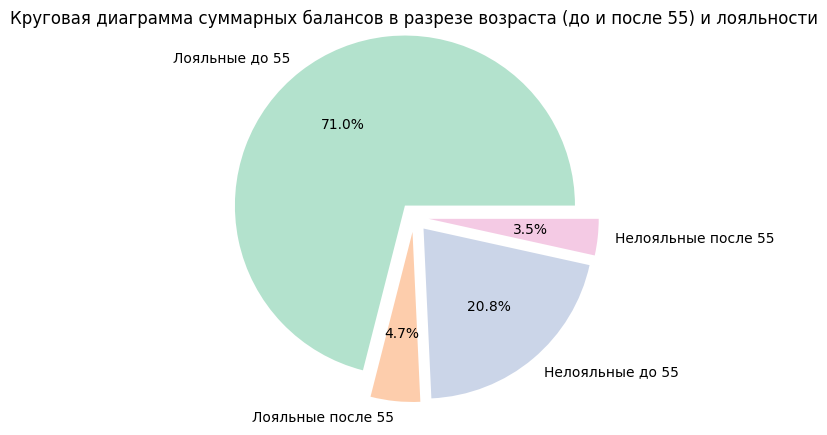

In [107]:
plt.pie(churn_age_exit_balance,
        labels=['Лояльные до 55', 'Лояльные после 55', 'Нелояльные до 55', 'Нелояльные после 55'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        explode = (0.1, 0.1, 0.1, 0.1),
        radius=1.15)
plt.title("Круговая диаграмма суммарных балансов в разрезе возраста (до и после 55) и лояльности")

Доля средств нелояльных клиентов за 55, составляет 3,5% от полной суммы балансов клиентов и 17% от общей суммы средств нелояльных клиентов, в то время как доля  лояльных клиентов этой возрастной группы среди всех лояльных клиентов всего 6,6%.
Суммарные объёмы денежных средств у лояльных и нелояльных клиентов старше 55 лет в целом примерно одного порядка
и видимо отражают возрастную струкуру вкладов.

Теперь посмотрим как распределены средства по счетам мужчин

In [108]:
churn_age_exit_balance_m=churn_df[churn_df['Gender']=='Male'].groupby(['Exited', churn_df['Age']>55]).Balance.sum()

Text(0.5, 1.0, 'Круговая диаграмма суммарных балансов мужчин в разрезе возраста (до и после 55) и лояльности')

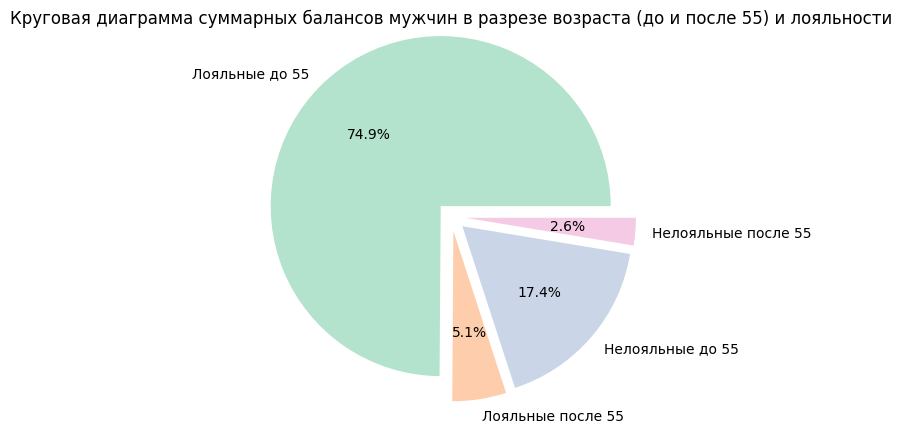

In [109]:
plt.pie(churn_age_exit_balance_m,
        labels=['Лояльные до 55', 'Лояльные после 55', 'Нелояльные до 55', 'Нелояльные после 55'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        explode = (0.1, 0.1, 0.1, 0.1),
        radius=1.15)
plt.title("Круговая диаграмма суммарных балансов мужчин в разрезе возраста (до и после 55) и лояльности")

На нелояльных клиентов-мужчин приходится всего лишь 2,6% средств на счетах клиентов банка,
и эта сумма в 2 раза меньше суммы счетов лояльных мужчин этой возрастной категории.
По всей видимости серьёзного недовольства услугами банка у мужчин этого возраста нет и они вполне ему лояльны.
Теперь посмотрим какова доля средств нелояльных женщин старше 55 лет?

In [110]:
churn_age_exit_balance_f=churn_df[churn_df['Gender']=='Female'].groupby(['Exited', churn_df['Age']>55]).Balance.sum()

Text(0.5, 1.0, 'Круговая диаграмма суммарных балансов женщин в разрезе возраста (до и после 55) и лояльности')

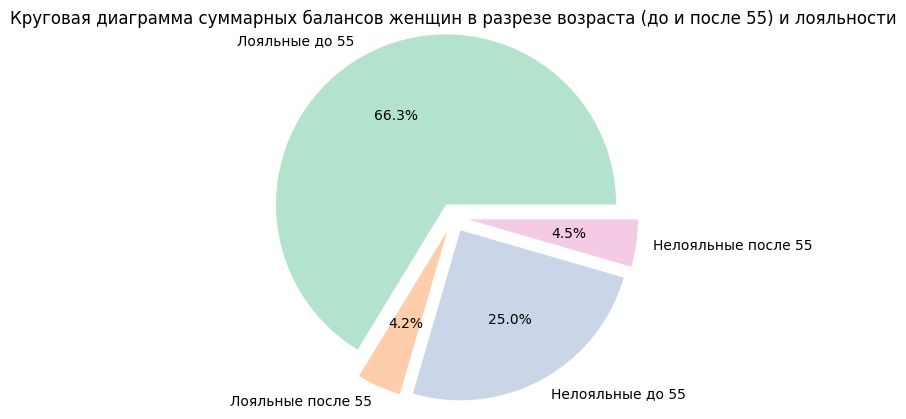

In [111]:
plt.pie(churn_age_exit_balance_f,
        labels=['Лояльные до 55', 'Лояльные после 55', 'Нелояльные до 55', 'Нелояльные после 55'],
        colors=sns.color_palette('Pastel2'),
        autopct='%.1f%%',
        explode = (0.1, 0.1, 0.1, 0.1),
        radius=1.15)
plt.title("Круговая диаграмма суммарных балансов женщин в разрезе возраста (до и после 55) и лояльности")

Нелояльные женщины старшее 55 имеют на своём балансе почти 5% средств банка. Банку следует выяснить причину нелояльности
этой клиентской группы и внести необходимые коррективы.

Исходя из вышесказанного, банку следует фокусироваться на потенциально нелояльных клиентах старше 55 лет и разработать для них программы повышения лояльностим с основным упором на клиентов женского пола.

### 5. Взаимосвязь кредитного рейтинга клиента и его предполагаемой зарплаты

Выясним имеется ли связь между кредитным рейтингом клиентов и их зарплатами. Для этого построим парный график показывающий характер зависимости между предикторами и характер их распределений.

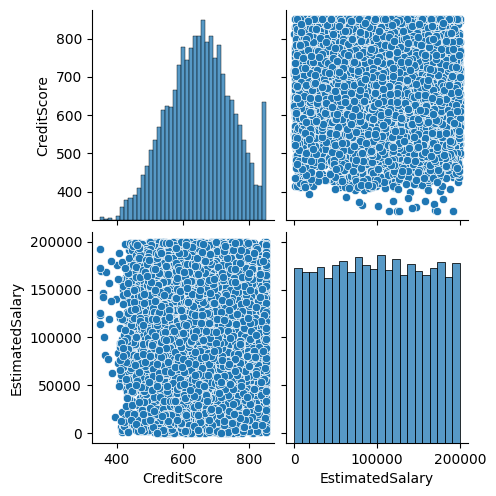

In [112]:
sns.pairplot(churn_df[['CreditScore','EstimatedSalary']])

Как мы видим, распределение оценок заработных плат близко к прямоугольному
а распределение кредитных рейтингов близко к нормальному, но справа отмечается вторая мода распределения. Определим моды. Зависимость между признаками отсутствует. Посмотрим как ведут себя признаки в разрезе лояльности

Text(0.5, 1.0, 'Зависимость оценки зарплаты от кредитного рейтинга')

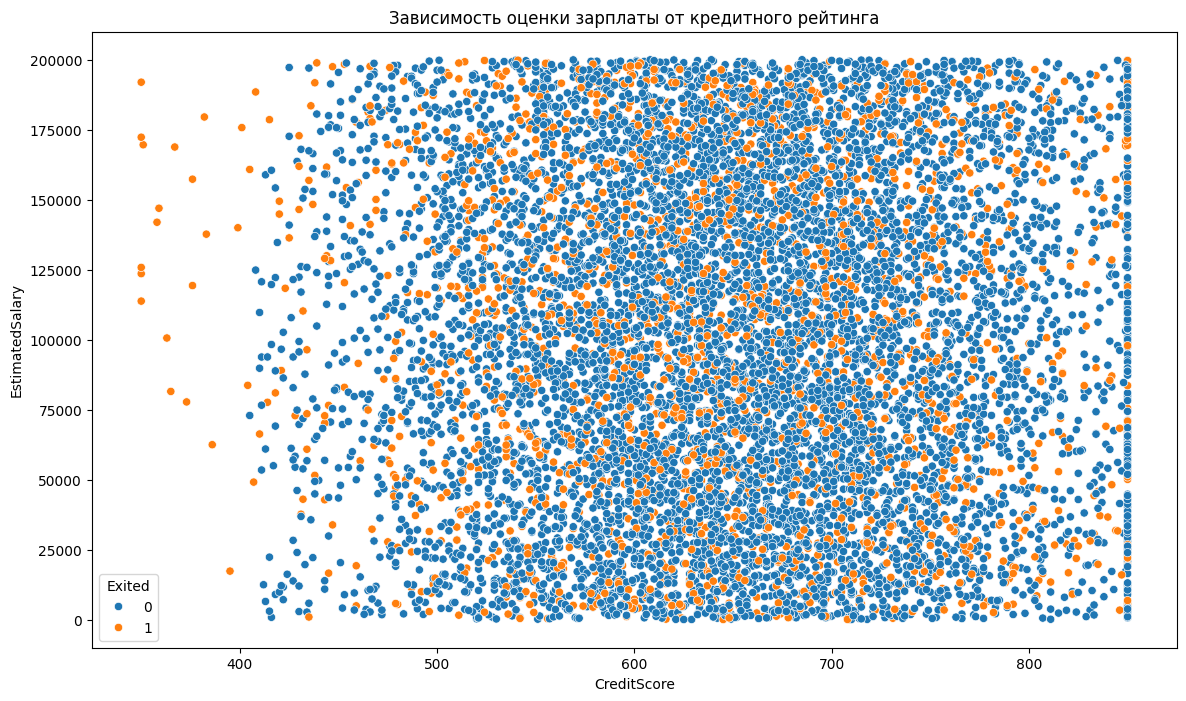

In [113]:
fig=plt.figure(figsize=[14, 8])
sns.scatterplot(x=churn_df['CreditScore'],
                y=churn_df['EstimatedSalary'],
                hue= churn_df['Exited']).set_title("Зависимость оценки зарплаты от кредитного рейтинга")

Мы отчётливо видим на графике, что в зоне кредитного рейтинга до 400 единиц, присутствуют только нелояльные клиенты с различными уровнями зарплат. Интересно отметить, что для этой группы клиентов имеется слабая отрицательная зависимость между зарплатами и кредитным рейтингом. Возможным объяснением является меньшее внимание уделяемое высокооплачивыми клиентами своей кредитной репутации. Учитывая низкий скоринг, банку следует подумать, целесообразно ли вовлечение подобных им клиентов в программы лояльности, или их уход в интересах банка.

Text(0.5, 1.0, 'Низкорейтинговые нелояльные клиенты')

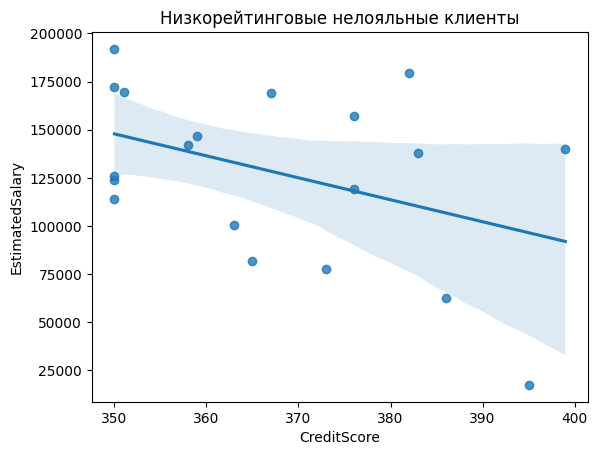

In [114]:
sns.regplot(x=churn_df[churn_df['CreditScore']<400]['CreditScore'],
            y=churn_df[churn_df['CreditScore']<400]['EstimatedSalary'],
            data=churn_df).set_title("Низкорейтинговые нелояльные клиенты")

Сравним медианные значения ненулевых балансов для всей совокупности ненулевых счетов и для счетов клиентов с кредитными рейтингами <400.

In [115]:
churn_df[churn_df['CreditScore']<400][churn_df['Balance']>0]['Balance'].median()

127707.645

In [116]:
churn_df['Balance'][churn_df['Balance']>0].median()

119839.69

Баланс счёта у низкорейтинговых клиентов медианно выше медианного значения по всей совокупности. Таким образом рейтинг для этой группы скорее всего отражает не финансовое положение клиента, а его отношение к банку.

Таким образом, у нас появляется ещё один диагоностический признак потенциально нелояльного клиента: кредитный рейтинг менее 400 единиц.

### 7. Зависимость оттока клиентов  от количества приобретённых у банка услуг.

Проверим, связано ли количество услуг оказываемых банком клиентам с их лояльностью.
Для определения характера зависимости построим многоуровневую столбчатую диаграмму.

In [117]:
services_churn=churn_df.groupby('Exited').NumOfProducts.value_counts().unstack()
services_churn

NumOfProducts,1,2,3,4
Exited,,,,
0,3675.0,4242.0,46.0,NaN
1,1409.0,348.0,220.0,60.0


In [118]:
mapping={services_churn.index[0]:"Лояльные", services_churn.index[1]: "Нелояльные"}
services_churn=services_churn.rename(index=mapping)

Text(0, 0.5, 'Количество клиентов')

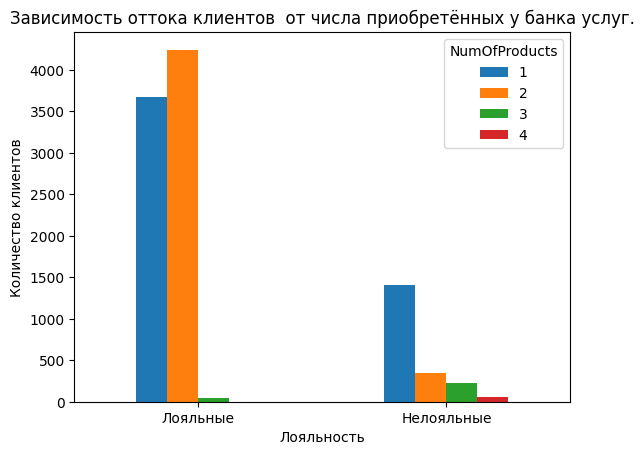

In [119]:
service_churn_bars=services_churn.plot(kind='bar', xlabel="Лояльность" )
plt.xticks(rotation = 0)

service_churn_bars.set_title('Зависимость оттока клиентов  от числа приобретённых у банка услуг.')
service_churn_bars.set_ylabel('Количество клиентов')

Лояльные клиенты в большинстве случаев предпочитают иметь один или два продукта, три услуги приобретаются очень редко,
а четырьмя услугами не пользуется ни один из клиентов сохранивших лояльность. Посмотрим каково распределение встречаемости трёх услуг в разрезе лояльности

In [120]:
triple_service_loyality=services_churn.loc["Лояльные",3]*100/(services_churn.loc["Лояльные",3]+services_churn.loc["Нелояльные",3])
print(str(round(triple_service_loyality, 1))+'%')

17.3%


То есть тремя услугами воспользовались и остались в банке только 17% клиентов от всех воспользовавшихся тремя услугами. Таким образом, в группу риска входят клиенты имеющие более двух продуктов. Для моделирования имеет смысл использовать бинарную переменную наличия/отсутствия 3-х или 4-х услуг.

Непонятно, предлагались ли эти услуги банком, или клиент самостоятельно их выбрал. Если клиент не имел необходимости в этих услугах и их предложил банк, возможно именно большое количество услуг вызвало нелояльность (к примеру стоимость обслуживания оказались выше чем ожидал клиент, либо предлагались услуги недостаточно проработанные с точки зрения подддержки).

Однако, возможна ситуация когда клиент действительно нуждался в помощи и именно поэтому ему были предложены какие-то дополнительные услуги, которые ему не помогли, а только усугубили ситуацию.

В любом случае, не рекомендуется предлагать клиенту более 2-х услуг.

### 8. Связь активности клиента с его лояльностью.

Интуитивно мы склонны предполагать что активные клиенты довольны своим сотрудничеством с банком и не стремятся его покинуть. Проверим, так ли это?

In [121]:
activity_churn=churn_df.groupby(['IsActiveMember', 'Exited']).CustomerId.count().unstack()

Text(0.5, 1.0, 'Тепловая диаграмма активность-отток')

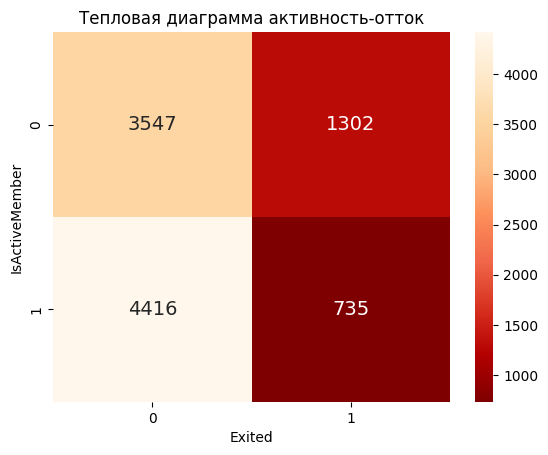

In [122]:
sns.heatmap(activity_churn,
            cmap='OrRd_r',
            annot=True,
            annot_kws={"size": 14},
            fmt="1"
           ).set_title("Тепловая диаграмма активность-отток")

Из тепловой диаграммы следует что активные клиенты значительно лояльнее неактивных. Использование данного признака поможет оценить лояльность клиентов, и при необходимости запустить программу лояльности для неактивных клиентов.

### 9. Географические аспекты лояльности.

При изучении датасета мы обнаружили что данные имеются по 3 странам. Посмотри какова частота оттока клиентов в этих странах

In [126]:
churn_country=churn_df.groupby(['Geography','Exited']).CustomerId.count().unstack()
mapping={churn_country.columns[0]:"Loyals", churn_country.columns[1]:'Non-loyals'}
churn_country.rename(columns=mapping, inplace=True)
churn_country=pd.concat([churn_country, (churn_country['Non-loyals']/(churn_country['Loyals']+churn_country['Non-loyals']))], axis=1)
mapping = {churn_country.columns[2]: 'Ratio'}
churn_country.rename(columns=mapping, inplace=True)
round(churn_country.loc[:]['Ratio']*100, 2)

,Ratio
Geography,
France,16.15
Germany,32.44
Spain,16.67


Больше всего нелояльных клиентов зафиксировано в Германии (кажый третий),
во Франции и Испании практически идентичные показатели.

На Германию необходимо обратить особое внимание.

### 10. Зависимость лояльности от категоризированного кредитного рейтинга и клиентского стажа

Проведём категоризацию кредитного рейтинга:
    
* "Deep" для credit_score < 300:
* "Very_Poor" для credit_score >= 300 и credit_score < 500:
* "Poor" для credit_score >= 500 и credit_score < 601:
* "Fair" для redit_score >= 601 и credit_score < 661
* "Good" для credit_score >= 661 и credit_score < 781
* "Excellent" для credit_score >= 781 и credit_score < 851:
* "Top" для credit_score >= 851

Построим сводную таблицу категоризированный рейтинг-клиентский стаж для двух выборок:
    1) Для полной выборки.
    2) Для выборки с ненулевыми балансами.

In [137]:
def get_credit_score_cat(credit_score):
    if credit_score >= 300 and credit_score < 500:
        return "Very_Poor"
    elif credit_score >= 500 and credit_score < 601:
        return "Poor"
    elif credit_score >= 601 and credit_score < 661:
        return "Fair"
    elif credit_score >= 661 and credit_score < 781:
        return "Good"
    elif credit_score >= 781 and credit_score < 851:
        return "Excellent"
    elif credit_score >= 851:
        return "Top"
    elif credit_score < 300:
        return "Deep"


Tenure,0,1,2,3,4,5,6,7,8,9,10
credit_score_cat,,,,,,,,,,,
Excellent,27.50,20.83,13.73,16.83,13.19,23.33,24.14,12.77,19.61,27.08,25.49
Fair,21.74,21.56,21.30,21.65,19.72,20.69,23.64,17.11,20.90,19.00,20.54
Good,20.38,20.36,18.73,20.60,19.51,21.45,18.29,19.19,15.24,19.47,19.78
Poor,22.64,25.94,21.18,21.22,23.32,19.92,17.99,15.13,21.46,25.11,16.95
Very_Poor,44.44,25.37,15.15,28.57,29.31,14.93,22.54,20.63,25.35,22.95,33.33


Text(0.5, 1.0, 'Процент оттока по всем клиентам в зависимости от категоризированного рейтинга и клиентского стажа')

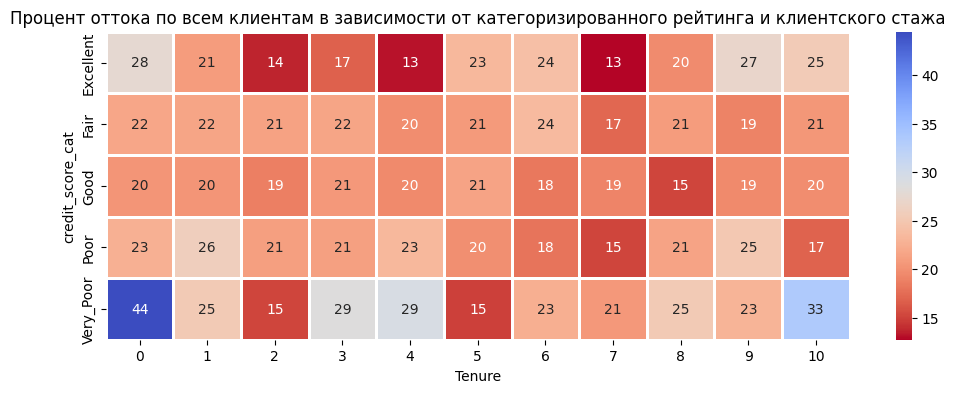

In [138]:
churn_df['credit_score_cat']=churn_df['CreditScore'].apply(get_credit_score_cat)
tenure_score_churn=churn_df.pivot_table(values='Exited',
                                        index='credit_score_cat',
                                        columns='Tenure',
                                        aggfunc='mean')*100
display(tenure_score_churn.round(2))
plt.figure(figsize=(12, 4))
sns.heatmap(tenure_score_churn, cmap='coolwarm_r', annot=True, linewidths=1).set_title("Процент оттока по всем клиентам в зависимости от категоризированного рейтинга и клиентского стажа")

Для полной совокупности клиентов мы видим что самый высокий отток клиентов наблюается в случае клиентоа с низким кредитным рейтингом до года.
Второй по величине отток фиксируется на 10 год сотрудничества с банком. Все остальные соотношения вроде не вызывают беспокойствия.
Но посмотрим что мы получили на ненулевой выборке клиентов банка?


Tenure,0,1,2,3,4,5,6,7,8,9,10
credit_score_cat,,,,,,,,,,,
Excellent,34.78,22.73,11.76,17.91,16.67,29.41,31.37,16.39,23.08,35.00,31.43
Fair,24.53,24.31,23.13,27.15,22.00,21.66,28.03,19.39,26.38,24.67,22.39
Good,23.36,22.52,20.00,24.07,23.01,27.82,22.71,22.22,19.82,24.11,21.67
Poor,28.21,31.10,23.46,27.39,27.27,25.71,21.68,18.31,27.56,29.14,18.42
Very_Poor,46.67,26.00,17.95,29.27,36.59,16.67,20.00,25.00,31.37,30.77,35.71


Text(0.5, 1.0, 'Процент оттока по всем клиентам в зависимости от категоризированного рейтинга и клиентского стажа')

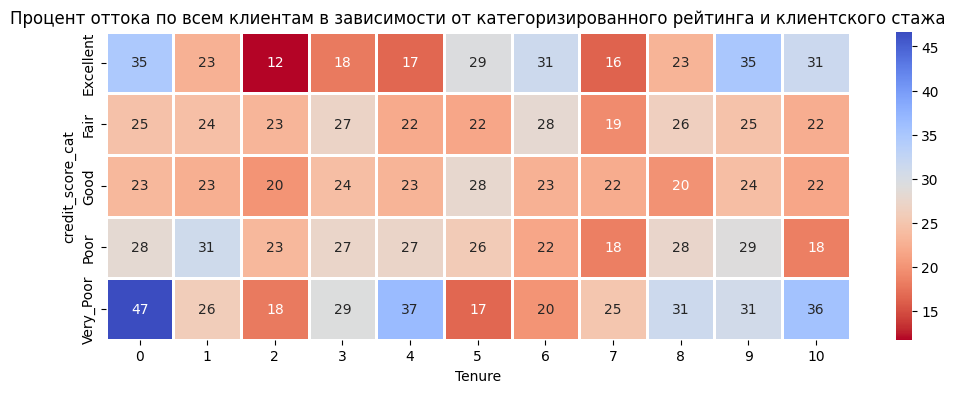

In [139]:
churn_df['credit_score_cat']=churn_df['CreditScore'].apply(get_credit_score_cat)
tenure_score_churn=churn_df[churn_df['Balance']>0].pivot_table(values='Exited', index='credit_score_cat', columns='Tenure', aggfunc='mean')*100
display(tenure_score_churn.round(2))
plt.figure(figsize=(12, 4))
sns.heatmap(tenure_score_churn, cmap='coolwarm_r', annot=True, linewidths=1).set_title("Процент оттока по всем клиентам в зависимости от категоризированного рейтинга и клиентского стажа")

Мы обнаруживаем что есть ещё одна проблемная категория, а именно высокорейтинговые клиенты.
С ними возникает проблема в первый год сотрудничества выливающаяся в 35% отток, далее ситуация сглаживается, но на 9-ом году случается рецидив равной магнитуды. Кроме того имеют места два всплеска магнитудой в 31% на 6 и 10 году. Поведение клиентов этой рейтинговой категории можно объяснить тем, что они знают себе цену и считают что могли бы получить от банка больше преференций. Необходимо предпринимать меры для их удержания на первом году сотрудничества,
а также обязательно ремотивировать их на 9  году. Возможно стоит провести мероприятия по повышению их лояльности через 5 лет после прихода клиента в банк,
приурочив их к пятилетнему юбилею сотрудничества.

Но как мы видим ниже и с клиентами самого низкого рейтинга всё обстоит сложнее чем мы могли бы предполагать базируясь на полном сете данных. Мы имеем для этой категории не только 47% отток в первый год, но и 2 мощных всплеска: на 10 год и не увиденный нами ранее всплеск на 4 год. Всплеску на 10 год предшествует также повышенный отток на 8 и 9 годы. Следовательно, если эта группа клиентов представляет для нас интерес, нам необходимо разработать мероприятия на 1 и 4 год сотрудничества с ними, а также программу лояльности начиная с 8-го года их пребывания в банке.

## Выводы:

1) Среди клиентов банка преобладают женщины, характер распределения по полам не зависит от лояльности клиента

2) Повышенный отток характерен для клиентов со значением баланса менее 50 и более 200 тысяч евро. Необходимы мероприятия по повышению лояльности, особенно для второго сегмента (трёхуровневая порядковая переменная)

3) Лояльные клиенты медианно моложе нелояльных на 10 лет. Верхняя граница интервала в который попадает большинство лояльных клиентов -55 лет, лишь немногие лояльные клиенты старше этого возраста. При этом, имеется достаточно много нелояльныхх клиентов в возрасте 55-70 лет. Поэтому возраст старше 55 лет перспективный признак для моделирования

4) Важно отметить, что особенную нелояльность демонстируют женщины старше 55 лет, на них следует обратить особое внимание(бинарный признак "женщина старше 55")

5) Ещё одним важны критерием риска потери клиента является его низкий кредитный рейтинг (не выше 400 ед.). В этом диапазоне показатель демонстрирует слабую отрицательную корреляцию с ожидаемой зарплатой. (бинарный признак)

6) Также фактором риска является пользование клиентом более двух услуг банка (бинарный признак)

7) Активность клиента более надёжный признак чем его неактивность, следовательно, активизация пассивных клиентов благотворно скажется на снижении оттока. Использование существующего признака "IsActiveMember"

8) Самые нелояльные клиенты банка-немцы, и на них следует обратить внимание. Возможна бинаризация признака "Германия"

9) Самая неблагополучная с точки зрения оттока категория это клиенты со стажем менее года, имеющие кредитный рейтинг между 300 и 500 единицами, а также клиенты с таким же рейтингом, но на 10 году работы с банком

10) При рассмотрении датасета с исключёнными позициями по которым баланс равен нулю, обнаружено, что неблагополучие также проявляют самы клиенты банка с самыми большими балансами счета. У них эти периоды приходятся на 1 и 6 годы, со всплеском на 9-10 годы. Рекомендуется повышение лояльности этих клиентов на 5 и 9 годах стажа. У клиентов из группы с минимальным балансом, поышенный отток наблюдается на 4 год стажа


    

## Вопросы которые необходимо уточнить для повышения адекватности модели:
    
1) какой отток клиентов является для банка приемлемым и не требующим повышения лояльности?

2) Каков порог суммарного баланса клиентов категории, выше которого целесообразны данные мероприятия?

3) Как правильно интерпретировать нулевой баланс, возможно имеется какая-то дополнительная информация?

4) Чем можно объяснить высокие зарплаты клиентов с низким рейтингом? На ум приходит только более высокая долговая нагрузка у клиентов с высокой зарплатой.

5) Что собой представляют услуги банка, есть ли каое-то ещё (в дополнение к моим предположениям) объяснение почему у нелояльных клиентов больше услуг? Вполне возможно что сопоставление этих услуг в разрезе лояльности значительно повысит точность прогноза оттока.